In [19]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import scipy.stats

import utils
import seaborn as sns 
import plotnine as pn
from sklearn.preprocessing import StandardScaler, scale


In [2]:
import importlib
importlib.reload(utils)


<module 'utils' from '/home/acercyc/projects/Keio Testing_analysis/src/utils.py'>

# Measuring dimensionality for each trial and each health subject

In [3]:
subjs, _ = utils.ExpInfo.getSubjIDs_byGroup()
task = utils.ExpInfo.taskName[0]

# compute dimensionality 
def add_dim(subj, task):
    df = utils.LoadData.behaviorData(subj, task)
    x, h, y = utils.LoadData.xhy(subj, task)
    dims = []
    for h_ in h:
        h_ = scale(h_, axis=0)
        dims.append(utils.Analysis.dim_measure(h_))
    df_ = df
    df_['dim'] = dims    
    return df_
    
df_all = utils.GroupOperation.map(add_dim, subjs, task)
df_all_ = pd.concat(df_all, axis=0)


|████████████████████████████████████████| 25/25 [100%] in 2.9s (8.74/s) 


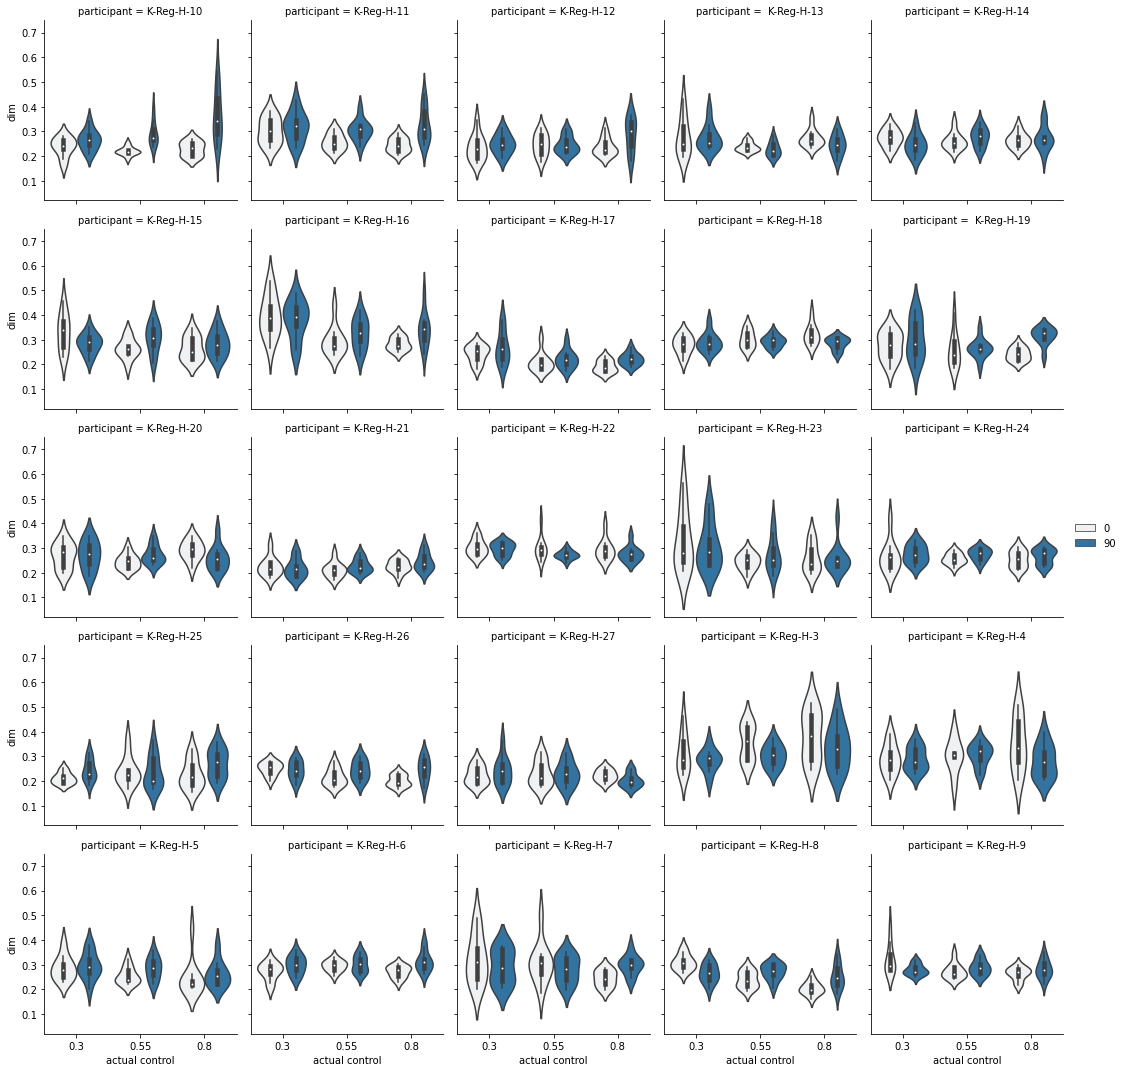

In [4]:
# plot dimensionality by conditions and subjects
grid = sns.FacetGrid(col='participant', col_wrap=5, data=df_all_)
grid.map_dataframe(sns.violinplot, 
                   x='actual control', 
                   y='dim', 
                   hue='angular bias')
grid.add_legend()


In [7]:
df_all_.head()

,participant,trial no.,actual control,angular bias,response,dim
0,K-Reg-H-10,1,0.30,0,0,0.264689
1,K-Reg-H-10,2,0.80,0,1,0.195716
2,K-Reg-H-10,3,0.30,0,0,0.239894
3,K-Reg-H-10,4,0.55,90,0,0.237551
4,K-Reg-H-10,5,0.30,90,0,0.249905


PlotnineError: 'stat_count() must not be used with a y aesthetic'

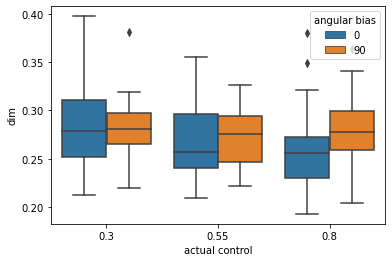

In [47]:
df_all_group = df_all_.copy()
df_all_group = df_all_group.drop(['trial no.', 'response'], axis=1)
df_all_group = df_all_group.groupby(['participant', 'actual control', 'angular bias'])
df_all_group = df_all_group.mean().reset_index()
# df_all_group = df_all_group.groupby()
# df_all_group.
sns.boxplot(x='actual control', y='dim', hue='angular bias', data=df_all_group)
# pn.ggplot(df_all_group, pn.aes(x="actual control", y='dim', fill='angular bias')) + pn.geom_bar()


## logistic regression on dimensionality and response

In [ ]:
def reg_dim_resp(subj, task):
    df_dim = add_dim(subj, task)
    df_dim = sm.add_constant(df_dim)
    logit_res = sm.Logit(df_dim['response'], df_dim[['dim', 'const']]).fit()
    return logit_res

logit_res = utils.GroupOperation.map(reg_dim_resp, subjs, task)

In [133]:
# extract coefficients and compute group t-test
dim_beta = [x.params['dim'] for x in logit_res]
scipy.stats.ttest_1samp(dim_beta, 0)

Ttest_1sampResult(statistic=-2.376005879805179, pvalue=0.02582898625194411)